### Task 2
# Prelude
### Imports

In [66]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from darkflow.net.build import TFNet
import cv2
import pprint as pp

from xml.etree import ElementTree
from xml.dom import minidom
from xml.etree.ElementTree import Element, SubElement, Comment
import glob
from os import listdir
from os.path import isfile, join
import os
import fnmatch
import pandas as pd
import h5py
import mat73
import csv
import json

### Tensorflow_shutup

In [2]:
# Mutes all the tensorflow warnings. Don't run tensorflow_shutup if you want warnings.
def tensorflow_shutup():
    """
    Make Tensorflow less verbose
    
    Source:
    https://stackoverflow.com/a/54950981
    """
    try:
        # noinspection PyPackageRequirements
        import os
        from tensorflow import logging
        logging.set_verbosity(logging.ERROR)
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

        # Monkey patching deprecation utils to shut it up! Maybe good idea to disable this once after upgrade
        # noinspection PyUnusedLocal
        def deprecated(date, instructions, warn_once=True):
            def deprecated_wrapper(func):
                return func
            return deprecated_wrapper

        from tensorflow.python.util import deprecation
        deprecation.deprecated = deprecated

    except ImportError:
        pass

tensorflow_shutup()

### Check current working directory
When writing to files in other directories the current working directory changes.
Run the code beneath to set the current working directory to the directory this file is placed.

In [3]:
current_working_dir = os.getcwd()
print("Current working directory is: " + current_working_dir)

correct_working_dir = "/home/fromsa_jonas_naphat_sondre_tord/inf368-exercise-2/Task2/darkflow"

if current_working_dir != correct_working_dir:
    os.chdir(correct_working_dir)
    print("Current working directory is: " +  os.getcwd())

Current working directory is: /home/fromsa_jonas_naphat_sondre_tord/inf368-exercise-2/Task2/darkflow


# Pipeline
1. Generate data using the script given from the raw fish and background images
2. Convert the labels and bounding box into an XML format that darkflow understands.
3. Load model (darkflow creates checkpoint weights that can be loaded for further training)
4. Train a darkflow implementation of yolov2 model on a training data
5. Sanity checks
6. Evaluate performance by calculating the mean Average Percision on the test data.

# 1. Generate data
Here we simply ran the code provided

# 2. Convert key data into XML format:

### Loading datasets from directories

In [22]:

test_images_path = 'generated_fish_dataset/test'
train_images_path = 'generated_fish_dataset/train'
val_images_path = 'generated_fish_dataset/val'

out_test_path = 'XML_data/test'
out_train_path = 'XML_data/train'
out_val_path = 'XML_data/val'

### Create XML versions of all generated data:
The YOLO architecture we are using requires all input to be in a specific XML format. This code converts all generated data into that format.

In [36]:
# Run this after all data has been generated

def run():
    """
    Runs the XML conversion for training, validation and test data.
    """
    create_XML_data(test_images_path, out_test_path)
    create_XML_data(train_images_path, out_train_path)
    create_XML_data(val_images_path, out_val_path)

run()

In [ ]:
def create_XML_data(input_path, output_path):
    """
    Creates the XML data for the input folder and puts the new data into the output folder.
    """
    
    pngs_masks_texts = [[],[],[]]
    
    adapters = ['/images/','/masks/', '/texts/']
    for i in range(len(adapters)):
        for file in os.listdir(input_path + adapters[i]):
            pngs_masks_texts[i].append(file)
        pngs_masks_texts[i].sort()
    
    for i in range(len(pngs_masks_texts[0])):
        xml = open(os.path.join(f'{output_path}/{i}.xml'),'w')
        xml.writelines(writeXML(input_path+adapters[0]+pngs_masks_texts[0][i],
                                input_path+adapters[1]+pngs_masks_texts[1][i],
                                input_path+adapters[2]+pngs_masks_texts[2][i]))
        xml.close()

In [ ]:
def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ElementTree.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

In [ ]:
def writeXML(image_png, mask_png, text):
    """
    Writes the XML code for the particular image, mask and text.
    """
    filename = str(image_png.split('/')[-1])
    height, width, depth = mpimg.imread(image_png).shape
    height, width, depth = str(height), str(width), str(depth)
    
    class_names, min_xs, min_ys, max_xs, max_ys = getAttributes(text)
    top = Element('annotation')


    img_name = SubElement(top, 'filename')
    img_name.text = filename

    size_tag = SubElement(top, "size")
    w_tag = SubElement(size_tag, "width")
    h_tag = SubElement(size_tag, "height")
    depth_tag = SubElement(size_tag, "depth")
    w_tag.text = width
    h_tag.text = height
    depth_tag.text = depth
    
    for i in range(len(class_names)):
        class_name, min_x, min_y, max_x, max_y = class_names[i], str(min_xs[i]), str(min_ys[i]), str(max_xs[i]), str(max_ys[i])
        obj_tag = SubElement(top, "object")
        
        name_tag = SubElement(obj_tag, "name")
        bound_tag = SubElement(obj_tag, "bndbox")
        name_tag.text = class_name
        
        xmin_tag = SubElement(bound_tag, "xmin")
        ymin_tag = SubElement(bound_tag, "ymin")
        xmax_tag = SubElement(bound_tag, "xmax")
        ymax_tag = SubElement(bound_tag, "ymax")
        xmin_tag.text = min_x
        ymin_tag.text = min_y
        xmax_tag.text = max_x
        ymax_tag.text = max_y
    
    return prettify(top)

In [ ]:
def getAttributes(text):
    """
    Returns the important information in the text file for the writeXML function.
    """
    # filename,labels,length,height,left,top,width
    open_text = open(text, 'r')
    
    lines = open_text.readlines()
    for i in range(len(lines)):
        lines[i] = lines[i][:-1]
    n_classes = len(lines)
    
    class_names =[]
    
    min_x = []
    min_y = []
    widths = []
    heights = []
    
    for line in lines:
        attr = line.split(' ')
        class_names.append(attr[0])
        min_x.append(int(attr[2]))
        min_y.append(int(attr[3]))
        widths.append(int(attr[4]))
        heights.append(int(attr[5]))
    
    max_x = []
    max_y = []
    for i in range(n_classes):
        max_x.append(min_x[i]+widths[i])
        max_y.append(min_y[i]+heights[i])
        
        #     y            y    y       n       n 
    return class_names, min_x, min_y, max_x, max_y
        

# Load data
Specify paths for the model and dataset

In [92]:
train_dataset_path = "TASK2/fish_generation/generated_fish_dataset/train/images"
train_label_path = "TASK2/fish_generation/XML_data/train"

test_dataset_path = "TASK2/fish_generation/generated_fish_dataset/test/images"
test_label_path = "TASK2/fish_generation/XML_data/test"

In [5]:
model_path = "cfg/tiny-yolo-4c.cfg"

# 3. Build model
Build model, providing spesifications for training: Which model to train, pre-trained weights, hyperparameters and dataset.

In [8]:
epochs = 30
batch_size = 8
learning_rate = 0.000001
gpu_precentage = 1.0 # 100 %

options = {"model": model_path,
           "load": -1, # -1 means: Use the weights saved at the last checkpoint
           "lr": learning_rate,
           "batch": batch_size,
           "epoch": epochs,
           "gpu": gpu_precentage,
           "train": True,
           "annotation": train_label_path,
           "dataset": train_dataset_path,
          }

# Set up network
tfnet = TFNet(options)

Parsing cfg/tiny-yolo-4c.cfg
Loading None ...
Finished in 0.00011038780212402344s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13

# 4. Train model

In [ ]:
tfnet.train()


cfg/tiny-yolo-4c.cfg parsing TASK2/fish_generation/XML_data/train
Parsing for ['Benthosema', 'BlueWhiting', 'Herring', 'Mackerel'] 
[====================>]100%  8290.xml
Statistics:
Benthosema: 5625
BlueWhiting: 5568
Mackerel: 5547
Herring: 5698
Dataset size: 9000
Dataset of 9000 instance(s)
Training statistics: 
	Learning rate : 1e-05
	Batch size    : 8
	Epoch number  : 30
	Backup every  : 2000
step 9627 - loss 4.6396965980529785 - moving ave loss 4.6396965980529785
step 9628 - loss 7.336940765380859 - moving ave loss 4.909421014785766
step 9629 - loss 3.617621898651123 - moving ave loss 4.780241103172303
step 9630 - loss 6.814369201660156 - moving ave loss 4.983653913021088
step 9631 - loss 4.867408275604248 - moving ave loss 4.9720293492794045
step 9632 - loss 5.419319152832031 - moving ave loss 5.016758329634667
step 9633 - loss 5.201793193817139 - moving ave loss 5.035261816052914
step 9634 - loss 4.461068153381348 - moving ave loss 4.977842449785758
step 9635 - loss 4.8607625961

step 9738 - loss 3.5414602756500244 - moving ave loss 4.448374641802167
step 9739 - loss 2.182131767272949 - moving ave loss 4.221750354349245
step 9740 - loss 4.279190540313721 - moving ave loss 4.227494372945693
step 9741 - loss 5.203936576843262 - moving ave loss 4.32513859333545
step 9742 - loss 4.306661605834961 - moving ave loss 4.323290894585401
step 9743 - loss 2.9644649028778076 - moving ave loss 4.1874082954146425
step 9744 - loss 5.069248676300049 - moving ave loss 4.275592333503184
step 9745 - loss 2.28993821144104 - moving ave loss 4.077026921296969
step 9746 - loss 2.420175075531006 - moving ave loss 3.9113417367203733
step 9747 - loss 4.165482521057129 - moving ave loss 3.936755815154049
step 9748 - loss 2.1339352130889893 - moving ave loss 3.7564737549475433
step 9749 - loss 3.9609501361846924 - moving ave loss 3.7769213930712584
step 9750 - loss 5.604691505432129 - moving ave loss 3.9596984043073453
step 9751 - loss 5.149011135101318 - moving ave loss 4.078629677386742

# 5. Sanity checks
Predict on images to manually evaluate the prediction, label and bounding box.
### Load model from checkpoint
Darkflow generates checkpoint files as it trains. To load the weights saved at the last checkpoint, run the code beneath.
"load": -1 tells the system to use the last checkpoint file.
Threshold = 0.1, meaning that if the model predicts an object with probability over 10 % it will give a result: label + bounding box

In [51]:
checkpoint = -1

options = {"model": model_path,
           "load": checkpoint,
           "gpu": 1.0,
           "json": True
          }
           
tfnet2 = TFNet(options)
tfnet2.load_from_ckpt()

Parsing cfg/tiny-yolo-4c.cfg
Loading None ...
Finished in 8.153915405273438e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13,

In [59]:
def set_box(original_img , predictions):
    '''Add bounding box and label to image'''
    newImage = np.copy(original_img)

    for result in predictions:
        top_x = result['topleft']['x']
        top_y = result['topleft']['y']

        btm_x = result['bottomright']['x']
        btm_y = result['bottomright']['y']

        confidence = result['confidence']
        label = result['label']
        
        newImage = cv2.rectangle(newImage, (top_x, top_y), (btm_x, btm_y), (255,0,0), 1)
        newImage = cv2.putText(newImage, label, (top_x-5, top_y+12), 1, 1, (0, 250, 0), 1)
        
    return newImage

In [97]:
def show_images(images):
    '''Show several images'''
    fig=plt.figure(figsize=(25, 25))
    columns = 4
    rows = 5
    for i in range(1, len(images)+1):
        fig.add_subplot(rows, columns, i)
        img = images[i-1]
        plt.imshow(img)
    plt.show()

### Find image with prediction

Found prediction for: 8.png
[{'label': 'Benthosema', 'confidence': 0.7569452, 'topleft': {'x': 549, 'y': 161}, 'bottomright': {'x': 653, 'y': 233}}, {'label': 'Benthosema', 'confidence': 0.66776955, 'topleft': {'x': 620, 'y': 148}, 'bottomright': {'x': 741, 'y': 251}}, {'label': 'Benthosema', 'confidence': 0.90220416, 'topleft': {'x': 102, 'y': 396}, 'bottomright': {'x': 229, 'y': 491}}]


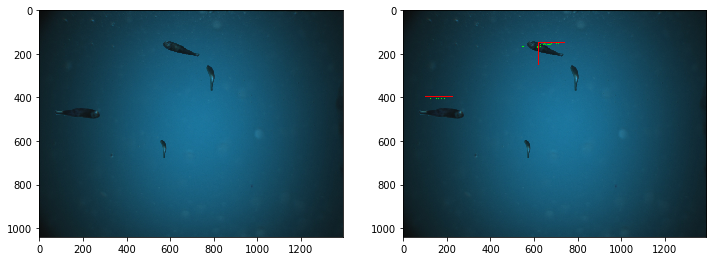

In [101]:
# Find image with prediction
for i in range(1, 500):
    image_path = train_dataset_path + "/train_mosaic_" + str(i) + ".png"
    im = get_image(image_path)
    res = tfnet2.return_predict(im)
    if(len(res)>0):
        print("Found prediction for: " + str(i) + ".png")
        print(res)
        new_and_old_image = [im, set_box(im, res)]
        show_images(new_and_old_image)
        break

### Predict on unseen data
Find the first 20 images from the test dataset that has a prediction from the model

In [98]:
# Store predictions for the 20 first images that have a prediction

# Number of images in test dataset
n_images = len(os.listdir(test_dataset_path))

images = []
image_attemps = 0
prediction_count = 0
i = 1
while (prediction_count < 20):
    image_path = test_dataset_path + "/test_mosaic_" + str(i) + ".png"
    i += 1
    image = cv2.imread(image_path)
    results = tfnet2.return_predict(image)
    if len(results) != 0:
        prediction_count += 1
        image_bbox = set_box(image, results)
        images.append(image_bbox)

The model managed to predict on 20 out of 58


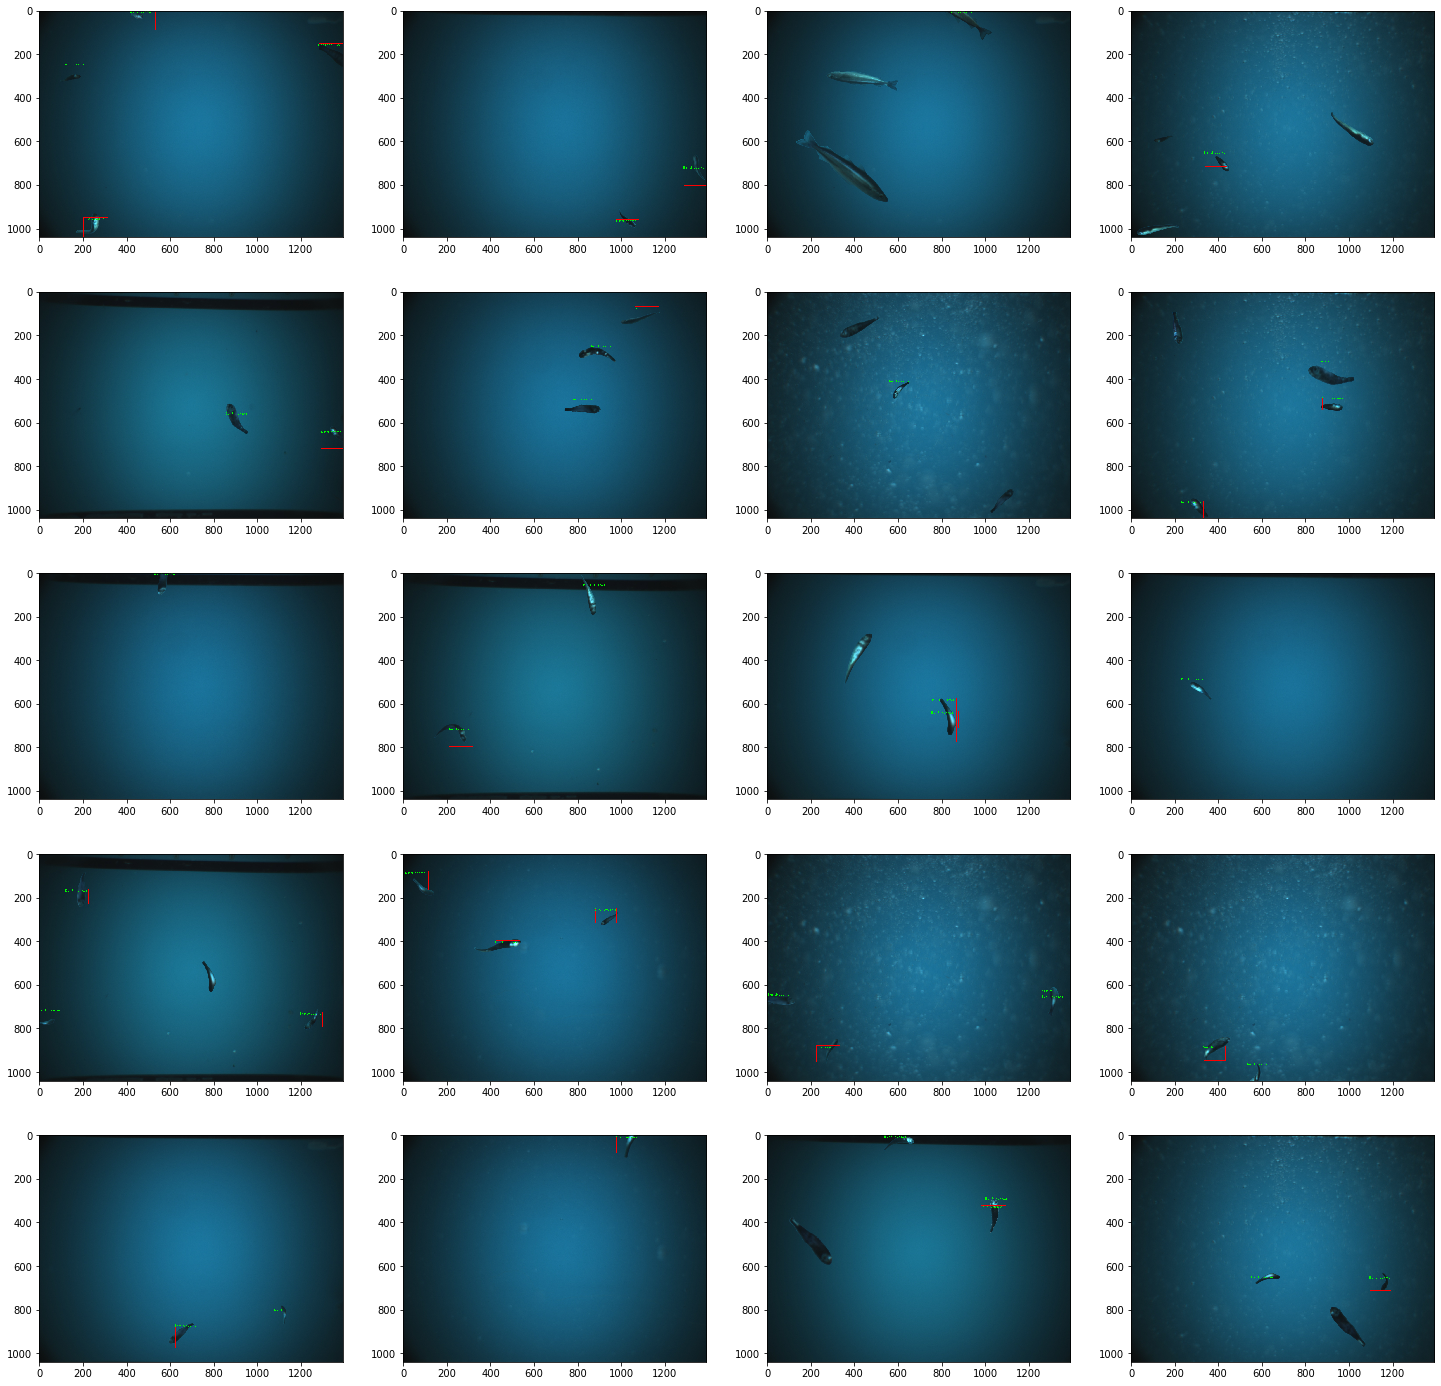

In [96]:
print("The model managed to predict on " + str(prediction_count) + " out of " + str(i-1))
show_images(images)

## Evaluate the model
To evaluate the performance of the neural network we will use the mAP criterium, Mean Average Precission, as defined in the PASCAL VOC 2012 competition.
### Write predictions to JSON
To evaluate the model we will calculate the mean Average Precission (mAP) on the test dataset. Firstly we predict labels and bounding boxes on the test dataset and store the predictions in json files. Then we preceed to convert the json files to appropriate txt files for the calculation of mAP.

To convert the files to json and then calcualte the mean Average Precision we are using code from:
https://github.com/Cartucho/mAP

In [99]:
# Number of images in test dataset
n_images = len(os.listdir(test_dataset_path))

# Path for where to put the json files
json_dir = "mAP/input/detection-results" 

# For each predicton on an image, create a Json file with prediction
for i in range(n_images):
    image_path = test_dataset_path + "/test_mosaic_" + str(i) + ".png"
    image = cv2.imread(image_path)
    results = tfnet2.return_predict(image)
    if len(results) != 0: 
        print("Prediction on image: test_mosaic_" + str(i) + ".png")
        with open(json_dir + "/" + str(i) + '.json', 'w+') as f:
            json.dump(str(results), f, ensure_ascii=False)

In [76]:
# Convert correct labels
%run ./mAP/scripts/extra/convert_gt_xml.py
os.chdir(correct_working_dir)

Conversion completed!


In [100]:
# Convert Json prediction files to txt files
%run ./mAP/scripts/extra/convert_dr_darkflow_json.py
os.chdir(correct_working_dir)

Conversion completed!


In [78]:
# Move all images that do not have a prediction to a sepearate folder before calculating mAP
%run ./mAP/scripts/extra/intersect-gt-and-dr.py
os.chdir(correct_working_dir)

total ground-truth files: 1000
total detection-results files: 405

total ground-truth backup files: 723
total detection-results backup files: 128
total intersected files: 277
Intersection completed!


### Calculate mean Average Precision

0.01% = Benthosema AP 
0.00% = BlueWhiting AP 
0.00% = Herring AP 
0.00% = Mackerel AP 
mAP = 0.00%


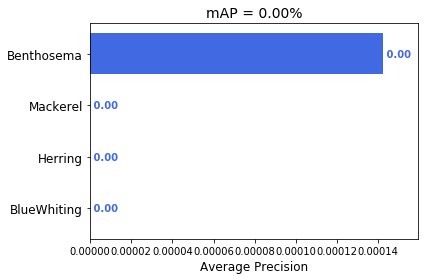

In [79]:
%run ./mAP/main.py -na
os.chdir(correct_working_dir)

# Conclusion

It seems as though the coordinates for the bounding box has been incorrectly placed, as seen by the sanity checks. This will then result in a very low Mean Average Precision (mAP), as seen in the graph above. 
This was only discovered at the very end of working on this assignment, and with the many days of training that had gone in to create the model we were not able to correct the coordinates and train again.

But, looking at the images in the sanity check section we see that the model is able to predict a decent amount. 
The number of images that was predicted on was 405 out of 1000 (40.5 %).

### Further work
Further work on this task would include:
 * Fixing the bounding box coordinates
 * Train longer
 * Try a different architecture. E.g. switching out Yolo V2 tiny with regular Yolo V2